# Markov Chain and Metropolis-Hastings.
__Big picture:__ The Markov Chain is a class of random processes, characterized by a transition probability from a state $x$ to the next state $y$. A Markov Chain can be designed to sample some particular distribution, $P(x)$. 

## MC Definition; Transition Probability Matrix

Suppose some system has a state described by $x\in \Omega$. A Markov Chain is a series of states $ \left\{ x_0,x_1,x_2,... \right\}$ selected by a random process in which the selection of state $x_{i+1}$ depends only on the state immediately prior, $x_i$. That is,
$$
    \Pr(x_{i+1}=z\,|\,x_i,x_{i-1},x_{i-2},...) = \Pr(x_{i+1}=z \,|\, x_i=y) = T_{yz},
$$
where $T_{yz}$ is called the transition probability matrix.

__Comment:__ The term _system_ should be interpreted quite broadly. It could be a physical system, but is in no way limited to physical systems.

__Comment:__ The Roman letter $x$ is used for convenience. The state could be an integer, a real or complex number, a vector, a function, or even a heterogeneous collection of mathematical objects. The theorems associated with Markov chains and Metropolis-Hastings (below) generally assume a finite domain $\Omega$. With care, though, we can work with infinite domains.

## Detailed Balance
Under certain assumptions, the sequence of states that come out of the Markov chain converge toward an equilibrium probability distribution $U(x)$, such that 
$$
    U(x)\, T_{xy} = U(y)\, T_{yx}.
$$
The above condition is called _detailed balance_. If $U(x)$ is uniform, then $T$ is symmetric:
$$
    T_{xy} = T_{yx}.
$$

## Metropolis-Hastings
__Claim:__ Given a random process characterized by a symmetric transition probability matrix $T$, we can build a Markov chain with a desired equilibrium distribution $P(x)$ by the _Metropolis-Hastings algorithm_:
1. Propose a random jump from $x_i$ to $x_{i+1}$ based on a symmetric transition probability matrix, $T$.
1. If $P(x_{i+1}) \ge P(x_i)$:
    1. Accept the jump. Increment $i$.
    1. Return to step 1.
1. Generate a random number $0<\alpha<1$.
1. If $P(x_{i+1})/P(x_i) \ge \alpha$,
    1. Accept the jump. Increment $i$.
    1. Return to step 1.
1. Do not accept the jump. Let $x_{i+1} = x_i$. Increment $i$. Return to step 1.

A shorter way of saying it is:
1. Propose a random jump from $x$ to $y$ based on a symmetric $T_{xy}$.
1. If $P(y) / P(x) \ge 1$, accept the jump.
1. Otherwise, accept the jump with probability $P(y)/P(x)$.

The above version could possibly be misunderstood, so I gave the more explicit version of the algorithm first.


### Proof
Let's calculate the transition probability matrix, $M_{xy}$, for the above algorithm.

__Case 1:__ $P(y) > P(x)$

$$
    M_{xy}=T_{xy}; \quad M_{yx} = T_{yx} \frac{P(x)}{P(y)}.
$$

__Case 2:__ $P(y) < P(x)$
$$
    M_{xy} = T_{xy}\frac{P(y)}{P(x)}; \quad M_{yx} = T_{yx}.
$$

__Case 3:__ $P(y) = P(x)$
$$
    M_{xy} = T_{xy}; \quad M_{yx} = T_{yx}.
$$

In all three of the above cases, since $T_{xy}=T_{yx}$, the detailed balance condition is met:
$$
    P(x)\, M_{xy} = P(y)\, M_{yx}.
$$
Therefore, $P$ is the equilibrium distribution corresponding to $M$.

__Comment:__ A key feature of Metropolis-Hastings is that, to create a Markov chain that converges toward $P(x)$, all we need is a way to calculate the likelihood ratio, $P(y)/P(x)$. 

__If only we had an interesting problem that gives us likelihood ratios $P(y)/P(x)$, we would be in a position to solve that problem for the distribution $P(x)$ using Markov Chains and Metropolis-Hastings.__

## Demonstration
The following code demonstrates the Metropolis-Hastings algorithm using
$$
    T_{xy} = \begin{cases}
        \frac{1}{2a}, & |x-y|\le a ;\\
        0,           & \text{else}.
    \end{cases}, 
    \quad \text{and} \quad
    P(x) = \frac{1}{\sqrt{2\pi}c} e^{-(x-b)^2/2c^2}.
$$

In [1]:
# Parameters
x0   =  5.0  # Initial state
a    =  1.3  # Jump radius (for uniform distribution)
b    = -3.0  # Gaussian centroid
fwhm =  1.0  # Gaussian full width at half maximum

# Environment
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
%matplotlib notebook

c  =  fwhm/( 2*np.sqrt(2*np.log(2)) )  # Gaussian standard deviation

# Implement T_xy
def proposal(x): ## Uniform jump distribution with FWHM = a.
    return x + 2*a*(np.random.rand() - 0.5)

# Implement P(x)
def gaussian(x):
    return np.exp( -(x-b)**2/(2*c**2) )/( np.sqrt(2*np.pi)*c )

def glike(x,y):
    return gaussian(y)/gaussian(x)

# Metropolis-Hastings
def metro(x0=0, jump_func=proposal, likelihood_ratio=glike, N=1000):
    x = np.empty((N))
    x[0] = x0
    i=0
    misses=0
    for i in range(N-1):
        x[i+1] = jump_func(x[i])
        ratio = likelihood_ratio(x[i],x[i+1])
        if ratio < 1:
            if np.random.rand() > ratio:
                x[i+1] = x[i]
                misses+=1
    return x,(N-misses)/N

# Incorrect implementation of Metropolis-Hastings
def metro_wrong(x0=0, jump_func=proposal, likelihood_ratio=glike, N=1000):
    x = np.empty((N))
    x[0] = x0
    i=0
    misses=0
    while i < N-1:
        x[i+1] = jump_func(x[i])
        ratio = likelihood_ratio(x[i],x[i+1])
        if ratio >= 1:
            i+=1
        else:
            if np.random.rand() <= ratio:
                i+=1
            else:
                misses+=1
    return x,N/(N+misses)

# Choose which version of Metropolis to use.
metropolis = metro  # set to metro or metro_wrong

Acceptance rate =  0.47


<IPython.core.display.Javascript object>


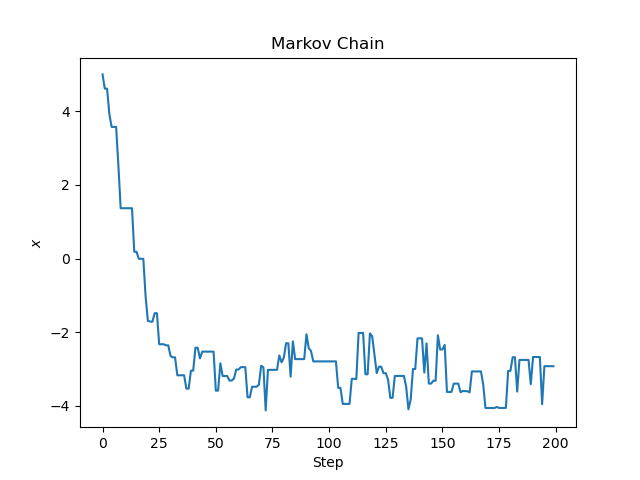

In [2]:
(x,acceptance_rate) = metropolis(x0=x0, N=200)
print('Acceptance rate = ',acceptance_rate)
plt.figure()
plt.plot(x)
plt.title(r'Markov Chain')
plt.xlabel(r'Step')
plt.ylabel(r'$x$')
plt.show();

### Points for discussion
1. In many applications the likelihood ratio is expensive to calculate. The performance of the Markov Chain is therefore optimal when we can characterize $P(x)$ with as few evaluations of the likelihood ratio as possible.
1. Let's define the _acceptance rate_ as the fraction of proposals that are accepted. 
    1. How would efficiency be affected by a low acceptance rate, perhaps 0.01?
    2. How would efficiency be affected by a high acceptance rate, perhaps 0.99?
    3. Roughly what acceptance rate would you aim for to maximize efficiency?
1. How do the jump width and the width of $P(x)$ influence the acceptance rate?

## Is $P(x)$ as predicted?
Once any initial transient ($x_0-b$) dies out, the Markov chain approaches its equilibrium distribution, $P(x)$. In my example, we expect the $x$ values to be distributed as a Gaussian with mean $b$ and standard deviation $c$. I will check this assertion using the Kolmogorov-Smirnov test, which is described in [my notes on non-parametric statistics](http://solar.physics.montana.edu/kankel/ph567/LectureNotes/07.1.Stats-nonparametric.pdf). It is also described in Section 14.3 of [Numerical Recipes in C](https://s3.amazonaws.com/nrbook.com/book_C210.html).

### How to get it wrong.
My first attempt at writing the function `metro()` is preserved above as `metro_wrong()`. Try substituting that in, and you'll see the CDF does not match expectations! Why? The two functions are written somewhat differently, but it comes down to what happens when the jump is not accepted. Do I keep drawing proposals until one is accepted, or do I just say $x_{i+1} \leftarrow x_i$ and move on?

In [3]:
# Generate a new Markov chain.

a  = 3.0    # Jump radius (half-width of uniform distribution)
b  = 0.0    # Gaussian mean
c  = 1.0    # Standard deviation
x0 = 0.0    # Initial state -- Start on the mean, so there's no transient.
Nx = 100000 # Let's have a larger dataset this time!

(x,acceptance_rate) = metropolis(x0=x0, N=Nx)
print('Acceptance rate = ',acceptance_rate)
sdev = np.std(x)
print('Standard deviation = ',sdev)

Acceptance rate =  0.49311
Standard deviation =  0.993907879187445


<IPython.core.display.Javascript object>


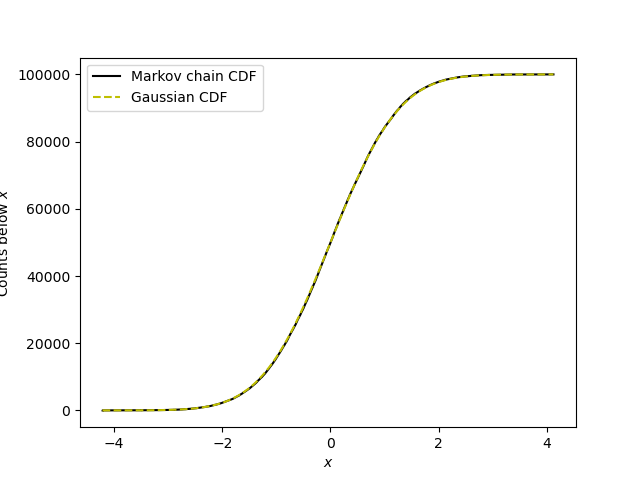

In [4]:
# Calculate the cumulative distribution
x_CDF = np.sort(x)
CDF = 0.5 + np.arange(Nx)
    # CDF just left of x_min is 0, and just to the right it is 1; 0.5 is a compromise. 
CDF_g = Nx*(1 + sp.erf(x_CDF/np.sqrt(2)))/2
plt.figure()
plt.plot(x_CDF,CDF, 'k-', label=r'Markov chain CDF')
plt.plot(x_CDF, CDF_g, 'y--', label=r'Gaussian CDF')
plt.ylabel(r'Counts below $x$')
plt.xlabel(r'$x$')
plt.legend()
plt.show()

### Markov chain autocorrelation
The above plot shows a good correspondence between the Markov chain and the cumulative distribution of the Gaussian. But before I can quantify how good it is, I need to understand how many independent Gaussian deviates are in my Markov chain.

Successive states of the Markov chain are not statistically independent. The sequence may be approximately described as [red noise](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week5/n_eff.html), 
$$
    x_n = \rho x_{n-1} + \epsilon_n \quad (n=1,2,3,...), \quad\text{with}\quad x_0 = \epsilon_0;
$$
where $\epsilon_n$ are a sequence of independent random numbers, such that $\left<\epsilon\right>=0$.
This results in an exponentially decaying autocorrelation at lag $n$:
$$
    a_n = \rho^n.
$$

Therefore a Markov chain with $N_x$ elements does not have $N_x$ independent degrees of freedom. Assuming the autocorrelation is normalized in the usual way ($a_0=1$), then the number of degrees of freedom is approximated as follows:
$$
    \boxed{ N_{\mathrm{eff}} = N_x \frac{1-\rho}{1+\rho}, }
$$
where $a_1\approx \rho$ is called the _lag-1 autocorrelation_. You will often see in texts on MonteCarlo that 
$$
    N_{\mathrm{eff}} = \frac{N_x}{\sum_{n=-\infty}^{\infty} a_n} = \frac{N_x}{1+2\sum_{n=0}^{\infty} a_n}.
$$
This reduces to the boxed equation if $a_n$ is given by the red noise approximation.

Nx =  100000 ; Effective sample size Neff =  26650.283587506954
Nx/Neff =  3.7523052867954365


<IPython.core.display.Javascript object>


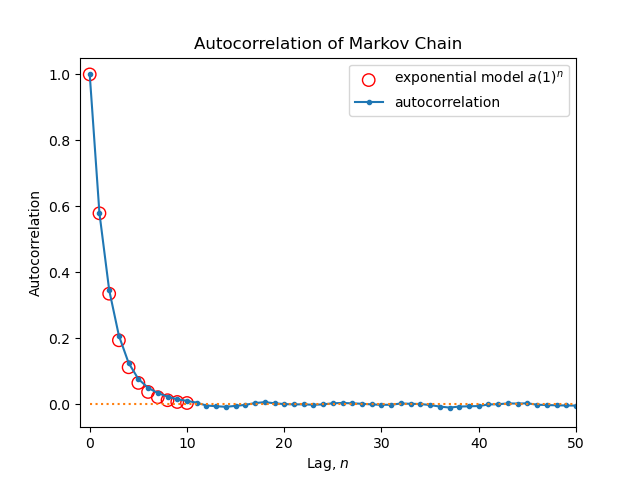

In [5]:
# Autocorrelation to estimate Neff.
# The lesson is that there are fewer independent random samples
# in the Markov chain than one might naively suppose.

# Estimate effective DOF using Lag-1 autocorrelation

# see https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]


autocorrelation = autocorr(x)
autocorrelation /= np.max(autocorrelation) # The usual normalization, a(0)=1
lag1 = autocorrelation[1]
Neff = Nx*(1-lag1)/(1+lag1)
print("Nx = ", Nx, "; Effective sample size Neff = ",Neff)
print("Nx/Neff = ",Nx/Neff)


plt.figure()
lag = np.arange(int(3*Nx/Neff))
amodel = lag1**lag
plt.scatter(lag,amodel,s=80, facecolors='none', edgecolors='r',label='exponential model $a(1)^n$')
plt.plot(autocorrelation,'.-',label='autocorrelation')
plt.plot(0*x,':')
plt.xlim((-1,50))
plt.xlabel('Lag, $n$')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Markov Chain')


plt.legend()
plt.show();



D =  0.004972728673362508
lambda =  0.8123937861122635
p-value =  0.5241157253661499

The null hypothesis (that the x array is drawn from the specified Gaussian
 distribution) is rejected (or not) with confidence  47.58842746338501 %


<IPython.core.display.Javascript object>


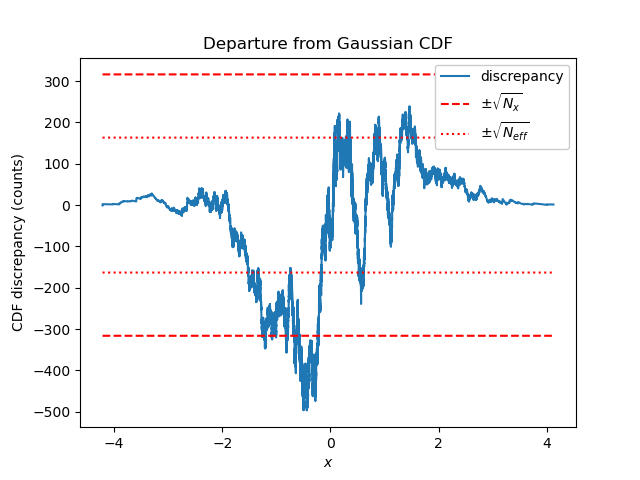

In [6]:
# Kolmogorov-Smirnov statistic (Numerical Recipes in C, equations 14.3.5, 7, 9)
discrepancy = CDF - CDF_g
D = (np.amax(np.abs(discrepancy)) + 0.5) / Nx
    # (see note in cell above about 0.5)
lam = D*( np.sqrt(Neff) + 0.12 + 0.11/np.sqrt(Neff) )
j = np.arange(1,100)
p = 2*np.sum( (-1)**(j-1) * np.exp(-2*j*j*lam*lam) )
print('D = ',D)
print('lambda = ',lam)
print('p-value = ',p)
print('\nThe null hypothesis (that the x array is drawn from the specified Gaussian\n',
      'distribution) is rejected (or not) with confidence ',100*(1-p),'%')

plt.figure()
plt.plot(x_CDF, discrepancy, label='discrepancy')
plt.plot(x_CDF, np.sqrt(Nx)*np.ones((Nx)), 'r--', label='$\pm\sqrt{N_x}$')
plt.plot(x_CDF, -np.sqrt(Nx)*np.ones((Nx)), 'r--')
plt.plot(x_CDF, np.sqrt(Neff)*np.ones((Nx)), 'r:', label='$\pm\sqrt{N_{eff}}$')
plt.plot(x_CDF, -np.sqrt(Neff)*np.ones((Nx)), 'r:')
plt.title('Departure from Gaussian CDF')
plt.ylabel(r'CDF discrepancy (counts)')
plt.xlabel(r'$x$')
plt.legend(loc='upper right', framealpha=1.0)
plt.show();



## Bimodal Distributions
The Markov chain can have difficulty exploring bimodal (or multi-modal) distributions. The chain can get stuck in one peak of the distribution, and you might think the distribution has been explored sufficiently when it really has not.

### Example

Acceptance rate =  0.4911
mean value =  2.494463387824023


<IPython.core.display.Javascript object>


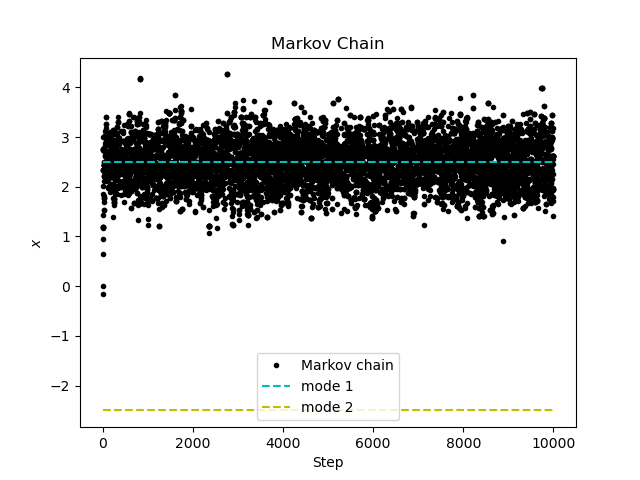

In [7]:
# Parameters
Nx   = 10000   # Number of Markov chain iterations
sep  =  5.0    # Separation of 2 Gaussians
x0   =  0.0    # Initial state
a    =  2.2    # Gaussian Jump FWHM
b1   =  sep/2  # Gaussian 1 centroid
b2   = -sep/2  # Gaussian 2 centroid
fwhm =  1.0    # Gaussian full width at half maximum
c  =  fwhm/( 2*np.sqrt(2*np.log(2)) )  # Gaussian standard deviation
# print('Gaussian standard deviation = ',c)

# Implement T_xy. Note that $a$ is now the FWHM of the Lorentzian jump distribution.
def gauss_jump(x):
    stdev = a/( 2*np.sqrt(2*np.log(2)) )  # Gaussian standard deviation
    return x + stdev * np.random.normal(loc=0.0, scale=stdev)

# Implement bimodal P(x)
def doublegaussian(x):
    return np.exp( -(x-b1)**2/(2*c**2) )/( np.sqrt(2*np.pi)*c ) + \
           np.exp( -(x-b2)**2/(2*c**2) )/( np.sqrt(2*np.pi)*c )

def dglike(x,y):
    return doublegaussian(y)/doublegaussian(x)

(x,acceptance_rate) = metropolis(x0=x0, jump_func=gauss_jump, likelihood_ratio=dglike, N=Nx)
print('Acceptance rate = ',acceptance_rate)
meanvalue = np.mean(x)
print('mean value = ', meanvalue)

plt.figure()
plt.plot(x,'k.',label='Markov chain')
plt.plot(np.array((0,Nx)),np.array((b1,b1)),'c--',label='mode 1')
plt.plot(np.array((0,Nx)),np.array((b2,b2)),'y--',label='mode 2')
plt.title(r'Markov Chain')
plt.xlabel(r'Step')
plt.ylabel(r'$x$')
plt.legend()
plt.show();

<IPython.core.display.Javascript object>


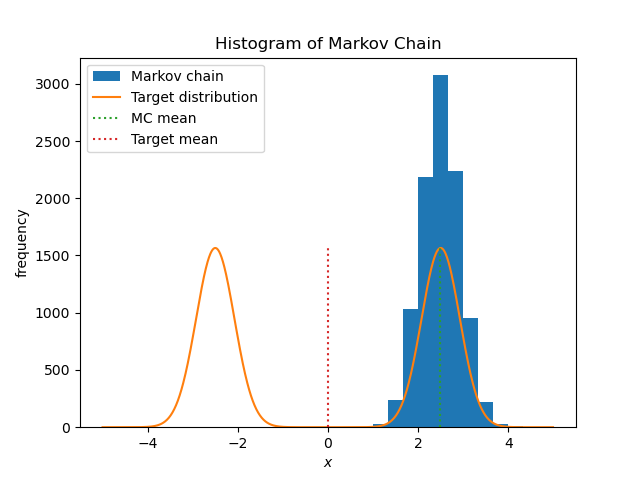

In [8]:
# Compare histogram to target distribution P(x)

Nbins = 30  # Number of histogram bins
dxhist = 2*sep/Nbins # Bin spacing for histogram
dx = 0.01   # Sample spacing for P(x)

plt.figure()
plt.title('Histogram of Markov Chain')
plt.xlabel('$x$')
plt.ylabel('frequency')
plt.hist(x,bins=Nbins, range=(-sep,sep),label='Markov chain')

xs = np.arange(-sep,sep,dx)
actual = doublegaussian(xs)
actual *= Nx*dxhist/(np.sum(actual)*dx)
plt.plot(xs,actual,label='Target distribution')
plt.plot([meanvalue,meanvalue], [0, np.amax(actual)],':', label='MC mean')
plt.plot([0,0], [0, np.amax(actual)],':', label='Target mean')
plt.legend()
plt.show();

### Aside: Generating random numbers from a known PDF ###
Numerical libraries commonly offer the capability to generate random numbers (deviates) with uniform, Gaussian, and Poissonian distributions. For many purposes, it is useful to know how to generate random numbers with some other probability distribution function (PDF). Given random number $x$ distributed according to PDF $F(x)$, we can generate a differently distributed parameter $y$ by defining $y=f(x)$ for some function $f$. What, then, would be the form of the distribution $G(y)$?
$$
    F(x)\,dx = G(y)\,dy.
$$
To obtain an expression for $G(y)$, we must assume that $f(x)$ is invertible. Let $g(y) \equiv f^{-1}(y)=x$. 
$$
    G(y) = F(g(y)) \frac{dg}{dy}.
$$

#### Lorentzian-distributed numbers
Suppose, for example, 
$$
    F(x) = \begin{cases}
        1, & -\frac{1}{2} \le x \le \frac{1}{2}, \\
        0, & \text{else}.
    \end{cases}
$$
This can be realized readily by taking the usual uniform deviates $\epsilon \in [0,1)$ and setting $x=\epsilon-\frac{1}{2}$. Now, let 
$$
    y = s \tan \pi x. \quad(1)
$$
It follows that
$$
    G(y) = \frac{1}{\pi} \frac{d}{dy} \left( \tan^{-1} \frac{y}{s} \right) = \frac{1}{\pi(s^2+y^2)},
$$
Consequently, the recipe (1) gives Lorentzian distributed numbers with $s$ equal to the half width at half maximum.

### Improved jump proposal function
The difficulty with multi-modal distributions can be ameliorated to some extent by modifying the jump proposal strategy. The `proposal2()` function below draws its proposals from a Lorentzian rather than a uniform distribution. Since the tails of the Lorentzian are very broad, very large jumps will occasionally be proposed, so that $P(x)$ is more thoroughly explored. To make a fair comparison, I have tuned the width of this Lorentzian to get a similar acceptance rate as with my original `proposal()` function.

My simple approach improves the behavior of the Markov chain for the example, but the result is still imperfect. Moreover, if you imagine a multidimensional state space, it could be difficult to discover another mode with just the occasional large jump. The state of the art in dealing with such problems is [parallel tempering](https://en.wikipedia.org/wiki/Parallel_tempering). 

In [9]:
# Implement T_xy. Note that $a$ is now the FWHM of the Lorentzian jump distribution.
def proposal2(x):
    return x + 0.5*a*np.tan(np.pi*(np.random.rand() - 0.5))

# Attempt to scale the Lorentzian so the acceptance rate is the same as for gauss_jump:
a *= 0.5  # If commented out, then the FWHM of proposal2 will be the same as for gauss_jump


Acceptance rate =  0.4812
mean value =  0.0028253682650101835


<IPython.core.display.Javascript object>


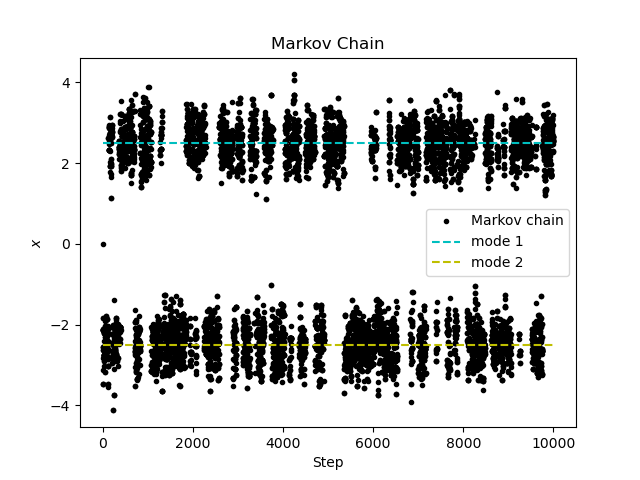

In [10]:
(x,acceptance_rate) = metropolis(x0=x0, jump_func=proposal2, likelihood_ratio=dglike, N=Nx)
print('Acceptance rate = ',acceptance_rate)
meanvalue = np.mean(x)
print('mean value = ', meanvalue)

plt.figure()
plt.plot(x,'k.',label='Markov chain')
plt.plot(np.array((0,Nx)),np.array((b1,b1)),'c--',label='mode 1')
plt.plot(np.array((0,Nx)),np.array((b2,b2)),'y--',label='mode 2')
plt.title(r'Markov Chain')
plt.xlabel(r'Step')
plt.ylabel(r'$x$')
plt.legend()
plt.show();

<IPython.core.display.Javascript object>


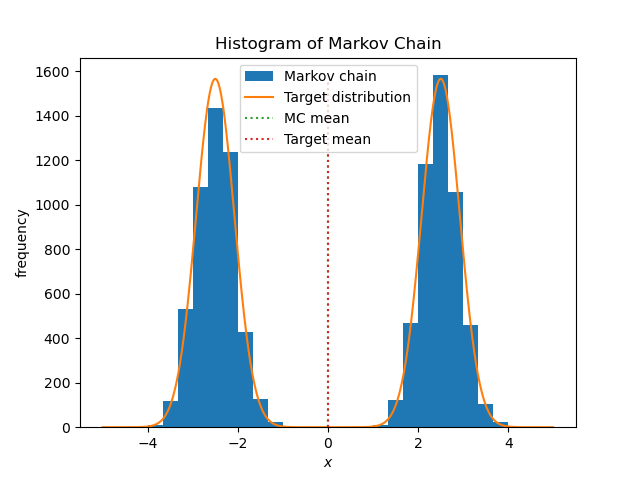

In [11]:
# Compare histogram to target distribution P(x)

Nbins = 30  # Number of histogram bins
dxhist = 2*sep/Nbins # Bin spacing for histogram
dx = 0.01   # Sample spacing for P(x)

plt.figure()
plt.title('Histogram of Markov Chain')
plt.xlabel('$x$')
plt.ylabel('frequency')
plt.hist(x,bins=Nbins, range=(-sep,sep),label='Markov chain')

xs = np.arange(-sep,sep,dx)
actual = doublegaussian(xs)
actual *= Nx*dxhist/(np.sum(actual)*dx)
plt.plot(xs,actual,label='Target distribution')
plt.plot([meanvalue,meanvalue], [0, np.amax(actual)],':', label='MC mean')
plt.plot([0,0], [0, np.amax(actual)],':', label='Target mean')
plt.legend()
plt.show();